In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import time
import quandl
import datetime
from sklearn.preprocessing import  MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split


from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
import pickle

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [3]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)



In [4]:
from library import get_data, normalize

In [5]:
indices = ["^GSPC","SPY","^IXIC", "^DJI", "^GDAXI", "^FTSE","^FCHI", "^N225","^HSI", "^AXJO","ORB"]


In [41]:
start_date = "2003-01-01"
end_date = "2017-01-01"
dates = pd.date_range(start_date, end_date) 

In [42]:
df_index = get_data(indices, dates)

In [43]:
df_index.fillna(method='ffill', inplace=True)# fill Nan with previos value as order is ascending date 
df_index.fillna(method='bfill', inplace=True)

In [44]:
X=df_index[["SPY","^IXIC", "^DJI", "^GDAXI", "^FTSE","^FCHI", "^N225","^HSI", "^AXJO","ORB"]]
y=df_index[["^GSPC"]]

In [45]:
X_normalized=normalize(X,X.columns)
y_normalized=normalize(y,y.columns)

In [46]:
df_final = X_normalized.join(y_normalized)

In [47]:
data=df_final.values

In [48]:
n_steps = 8
# convert into input/output
X, y = split_sequences(data, n_steps)

In [49]:
train_size = int(len(X) * 0.80)
X_train, X_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = y[0:train_size], y[train_size:len(X)]

In [50]:
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
n_features = 10
n_seq = 2
n_steps = 4
X = X_train.reshape((X_train.shape[0], n_seq, n_steps, n_features))

In [51]:
X[-1], y_train[-1]

(array([[[ 0.70776531,  0.72712152,  0.73771139,  0.70270854,  0.88845385,
           0.52146682,  0.5950236 ,  0.61351548,  0.66901623,  0.69767442],
         [ 0.7072078 ,  0.72670196,  0.73517624,  0.69432751,  0.88243689,
           0.52264074,  0.58387974,  0.5964869 ,  0.65671097,  0.69344609],
         [ 0.70202244,  0.72024035,  0.7301545 ,  0.69848509,  0.88139949,
           0.51703144,  0.59140673,  0.59668835,  0.65726805,  0.69260042],
         [ 0.70230124,  0.72406611,  0.72932264,  0.68677626,  0.86464549,
           0.5054885 ,  0.5629032 ,  0.58086086,  0.65009813,  0.68727273]],
 
        [[ 0.69059244,  0.70915425,  0.71210504,  0.66997482,  0.84724311,
           0.49068149,  0.56186004,  0.5745813 ,  0.65697745,  0.68693446],
         [ 0.68769319,  0.70559399,  0.70888631,  0.67377161,  0.84052598,
           0.48161412,  0.52650794,  0.56525727,  0.63682383,  0.68794926],
         [ 0.69700444,  0.7137836 ,  0.72240699,  0.68600935,  0.85102964,
           0.496

In [52]:
# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='tanh'), input_shape=(None, n_steps, n_features)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(50, activation='tanh'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


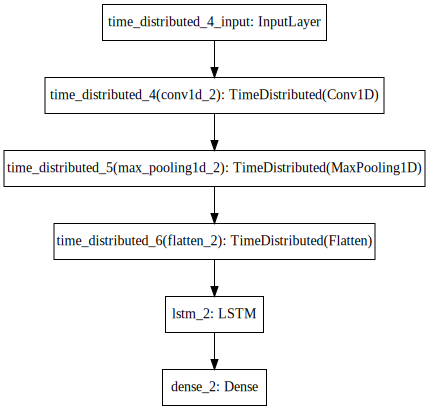

In [53]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [54]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_4 (TimeDist (None, None, 4, 64)       704       
_________________________________________________________________
time_distributed_5 (TimeDist (None, None, 2, 64)       0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, None, 128)         0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                35800     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 36,555
Trainable params: 36,555
Non-trainable params: 0
_________________________________________________________________


In [55]:
# fit model
history=model.fit(X, y_train, epochs=1500, verbose=2, validation_split=0.15, shuffle=False)

Train on 2391 samples, validate on 423 samples
Epoch 1/1500
 - 3s - loss: 0.0016 - val_loss: 0.0034
Epoch 2/1500
 - 0s - loss: 7.7749e-04 - val_loss: 0.0092
Epoch 3/1500
 - 0s - loss: 0.0016 - val_loss: 0.0323
Epoch 4/1500
 - 0s - loss: 0.0028 - val_loss: 0.0467
Epoch 5/1500
 - 0s - loss: 0.0032 - val_loss: 0.0211
Epoch 6/1500
 - 0s - loss: 0.0031 - val_loss: 0.0069
Epoch 7/1500
 - 0s - loss: 0.0027 - val_loss: 0.0071
Epoch 8/1500
 - 0s - loss: 0.0024 - val_loss: 0.0124
Epoch 9/1500
 - 0s - loss: 0.0031 - val_loss: 0.0136
Epoch 10/1500
 - 1s - loss: 0.0030 - val_loss: 0.0144
Epoch 11/1500
 - 0s - loss: 0.0027 - val_loss: 0.0138
Epoch 12/1500
 - 0s - loss: 0.0024 - val_loss: 0.0105
Epoch 13/1500
 - 0s - loss: 0.0013 - val_loss: 0.0094
Epoch 14/1500
 - 0s - loss: 0.0010 - val_loss: 0.0079
Epoch 15/1500
 - 0s - loss: 0.0015 - val_loss: 0.0075
Epoch 16/1500
 - 0s - loss: 0.0016 - val_loss: 0.0051
Epoch 17/1500
 - 0s - loss: 0.0018 - val_loss: 0.0027
Epoch 18/1500
 - 0s - loss: 0.0018 - val

Epoch 141/1500
 - 0s - loss: 2.1090e-04 - val_loss: 0.0037
Epoch 142/1500
 - 0s - loss: 1.7319e-04 - val_loss: 0.0096
Epoch 143/1500
 - 0s - loss: 2.1889e-04 - val_loss: 0.0108
Epoch 144/1500
 - 0s - loss: 2.4994e-04 - val_loss: 0.0017
Epoch 145/1500
 - 0s - loss: 4.1400e-04 - val_loss: 1.0731e-04
Epoch 146/1500
 - 0s - loss: 4.8427e-04 - val_loss: 6.9164e-04
Epoch 147/1500
 - 0s - loss: 2.3824e-04 - val_loss: 0.0023
Epoch 148/1500
 - 0s - loss: 1.7830e-04 - val_loss: 0.0079
Epoch 149/1500
 - 0s - loss: 2.3914e-04 - val_loss: 0.0092
Epoch 150/1500
 - 0s - loss: 2.0734e-04 - val_loss: 0.0029
Epoch 151/1500
 - 0s - loss: 3.2369e-04 - val_loss: 2.4781e-04
Epoch 152/1500
 - 0s - loss: 3.8824e-04 - val_loss: 0.0026
Epoch 153/1500
 - 0s - loss: 9.4247e-05 - val_loss: 7.7439e-04
Epoch 154/1500
 - 0s - loss: 1.3961e-04 - val_loss: 0.0025
Epoch 155/1500
 - 0s - loss: 3.0469e-04 - val_loss: 0.0059
Epoch 156/1500
 - 0s - loss: 1.0127e-04 - val_loss: 3.9501e-04
Epoch 157/1500
 - 0s - loss: 2.8821e

Epoch 276/1500
 - 0s - loss: 2.1939e-04 - val_loss: 3.8281e-04
Epoch 277/1500
 - 0s - loss: 1.8036e-04 - val_loss: 0.0015
Epoch 278/1500
 - 0s - loss: 1.7765e-04 - val_loss: 0.0016
Epoch 279/1500
 - 0s - loss: 1.9956e-04 - val_loss: 0.0051
Epoch 280/1500
 - 0s - loss: 2.1487e-04 - val_loss: 0.0060
Epoch 281/1500
 - 0s - loss: 1.2696e-04 - val_loss: 0.0036
Epoch 282/1500
 - 0s - loss: 1.3726e-04 - val_loss: 0.0015
Epoch 283/1500
 - 0s - loss: 1.7212e-04 - val_loss: 4.0035e-04
Epoch 284/1500
 - 0s - loss: 2.0514e-04 - val_loss: 4.5581e-04
Epoch 285/1500
 - 0s - loss: 2.1346e-04 - val_loss: 3.0911e-04
Epoch 286/1500
 - 0s - loss: 1.6174e-04 - val_loss: 0.0012
Epoch 287/1500
 - 0s - loss: 1.3737e-04 - val_loss: 0.0023
Epoch 288/1500
 - 0s - loss: 1.8262e-04 - val_loss: 0.0030
Epoch 289/1500
 - 0s - loss: 1.4775e-04 - val_loss: 0.0049
Epoch 290/1500
 - 0s - loss: 1.5334e-04 - val_loss: 0.0069
Epoch 291/1500
 - 0s - loss: 1.6258e-04 - val_loss: 0.0032
Epoch 292/1500
 - 0s - loss: 1.6849e-04 

 - 0s - loss: 2.5359e-04 - val_loss: 0.0056
Epoch 414/1500
 - 0s - loss: 1.1506e-04 - val_loss: 0.0064
Epoch 415/1500
 - 0s - loss: 1.4033e-04 - val_loss: 0.0059
Epoch 416/1500
 - 0s - loss: 1.9550e-04 - val_loss: 0.0043
Epoch 417/1500
 - 0s - loss: 9.4447e-05 - val_loss: 0.0023
Epoch 418/1500
 - 0s - loss: 1.3762e-04 - val_loss: 0.0025
Epoch 419/1500
 - 0s - loss: 1.4588e-04 - val_loss: 0.0047
Epoch 420/1500
 - 0s - loss: 8.1179e-05 - val_loss: 0.0076
Epoch 421/1500
 - 0s - loss: 9.2514e-05 - val_loss: 0.0035
Epoch 422/1500
 - 0s - loss: 7.5120e-05 - val_loss: 0.0035
Epoch 423/1500
 - 0s - loss: 1.0297e-04 - val_loss: 0.0030
Epoch 424/1500
 - 0s - loss: 1.2197e-04 - val_loss: 0.0019
Epoch 425/1500
 - 0s - loss: 1.6808e-04 - val_loss: 0.0037
Epoch 426/1500
 - 0s - loss: 1.3347e-04 - val_loss: 0.0018
Epoch 427/1500
 - 0s - loss: 1.4270e-04 - val_loss: 0.0032
Epoch 428/1500
 - 0s - loss: 1.3283e-04 - val_loss: 0.0037
Epoch 429/1500
 - 0s - loss: 1.4120e-04 - val_loss: 0.0053
Epoch 430/15

 - 0s - loss: 1.2360e-04 - val_loss: 0.0043
Epoch 553/1500
 - 0s - loss: 1.5129e-04 - val_loss: 0.0040
Epoch 554/1500
 - 0s - loss: 1.5193e-04 - val_loss: 0.0051
Epoch 555/1500
 - 0s - loss: 1.2330e-04 - val_loss: 0.0145
Epoch 556/1500
 - 0s - loss: 1.6398e-04 - val_loss: 0.0116
Epoch 557/1500
 - 0s - loss: 2.9621e-04 - val_loss: 0.0067
Epoch 558/1500
 - 0s - loss: 1.4246e-04 - val_loss: 0.0057
Epoch 559/1500
 - 0s - loss: 1.2560e-04 - val_loss: 0.0083
Epoch 560/1500
 - 0s - loss: 8.7630e-05 - val_loss: 0.0098
Epoch 561/1500
 - 0s - loss: 8.8233e-05 - val_loss: 0.0138
Epoch 562/1500
 - 0s - loss: 1.1251e-04 - val_loss: 0.0110
Epoch 563/1500
 - 0s - loss: 7.5455e-05 - val_loss: 0.0130
Epoch 564/1500
 - 0s - loss: 1.0207e-04 - val_loss: 0.0072
Epoch 565/1500
 - 0s - loss: 9.8381e-05 - val_loss: 0.0054
Epoch 566/1500
 - 0s - loss: 7.0876e-05 - val_loss: 0.0049
Epoch 567/1500
 - 0s - loss: 1.1613e-04 - val_loss: 0.0050
Epoch 568/1500
 - 0s - loss: 9.4144e-05 - val_loss: 0.0066
Epoch 569/15

Epoch 691/1500
 - 0s - loss: 1.0637e-04 - val_loss: 0.0025
Epoch 692/1500
 - 0s - loss: 1.2522e-04 - val_loss: 0.0063
Epoch 693/1500
 - 0s - loss: 1.2514e-04 - val_loss: 0.0065
Epoch 694/1500
 - 0s - loss: 1.1072e-04 - val_loss: 0.0071
Epoch 695/1500
 - 0s - loss: 2.5138e-04 - val_loss: 0.0050
Epoch 696/1500
 - 0s - loss: 1.3118e-04 - val_loss: 0.0086
Epoch 697/1500
 - 0s - loss: 1.5736e-04 - val_loss: 0.0078
Epoch 698/1500
 - 0s - loss: 1.1051e-04 - val_loss: 0.0066
Epoch 699/1500
 - 0s - loss: 1.3064e-04 - val_loss: 0.0056
Epoch 700/1500
 - 0s - loss: 1.9499e-04 - val_loss: 0.0034
Epoch 701/1500
 - 0s - loss: 1.7677e-04 - val_loss: 9.0841e-04
Epoch 702/1500
 - 0s - loss: 1.4883e-04 - val_loss: 0.0025
Epoch 703/1500
 - 0s - loss: 1.2541e-04 - val_loss: 0.0016
Epoch 704/1500
 - 0s - loss: 2.0114e-04 - val_loss: 0.0074
Epoch 705/1500
 - 0s - loss: 1.8148e-04 - val_loss: 0.0031
Epoch 706/1500
 - 0s - loss: 2.8461e-04 - val_loss: 0.0065
Epoch 707/1500
 - 0s - loss: 5.1344e-04 - val_loss: 

Epoch 830/1500
 - 0s - loss: 1.3397e-04 - val_loss: 0.0069
Epoch 831/1500
 - 0s - loss: 1.2325e-04 - val_loss: 0.0074
Epoch 832/1500
 - 0s - loss: 1.0572e-04 - val_loss: 0.0079
Epoch 833/1500
 - 0s - loss: 1.2527e-04 - val_loss: 0.0085
Epoch 834/1500
 - 0s - loss: 1.4397e-04 - val_loss: 0.0077
Epoch 835/1500
 - 0s - loss: 1.7461e-04 - val_loss: 0.0075
Epoch 836/1500
 - 0s - loss: 1.1781e-04 - val_loss: 0.0056
Epoch 837/1500
 - 0s - loss: 1.1405e-04 - val_loss: 0.0054
Epoch 838/1500
 - 0s - loss: 1.8148e-04 - val_loss: 0.0058
Epoch 839/1500
 - 0s - loss: 8.0679e-05 - val_loss: 0.0067
Epoch 840/1500
 - 0s - loss: 9.1410e-05 - val_loss: 0.0064
Epoch 841/1500
 - 0s - loss: 7.6672e-05 - val_loss: 0.0058
Epoch 842/1500
 - 0s - loss: 7.1869e-05 - val_loss: 0.0061
Epoch 843/1500
 - 0s - loss: 9.2611e-05 - val_loss: 0.0065
Epoch 844/1500
 - 0s - loss: 1.0073e-04 - val_loss: 0.0072
Epoch 845/1500
 - 0s - loss: 8.1818e-05 - val_loss: 0.0072
Epoch 846/1500
 - 0s - loss: 2.1127e-04 - val_loss: 0.00

Epoch 969/1500
 - 0s - loss: 5.1397e-05 - val_loss: 0.0054
Epoch 970/1500
 - 0s - loss: 5.1948e-05 - val_loss: 0.0053
Epoch 971/1500
 - 0s - loss: 6.4683e-05 - val_loss: 0.0056
Epoch 972/1500
 - 0s - loss: 8.8830e-05 - val_loss: 0.0056
Epoch 973/1500
 - 0s - loss: 8.9794e-05 - val_loss: 0.0053
Epoch 974/1500
 - 0s - loss: 6.9688e-05 - val_loss: 0.0049
Epoch 975/1500
 - 0s - loss: 1.0372e-04 - val_loss: 0.0049
Epoch 976/1500
 - 0s - loss: 1.2618e-04 - val_loss: 0.0052
Epoch 977/1500
 - 0s - loss: 1.4630e-04 - val_loss: 0.0038
Epoch 978/1500
 - 0s - loss: 1.6766e-04 - val_loss: 0.0033
Epoch 979/1500
 - 0s - loss: 1.9010e-04 - val_loss: 0.0033
Epoch 980/1500
 - 0s - loss: 2.2932e-04 - val_loss: 0.0037
Epoch 981/1500
 - 0s - loss: 1.9250e-04 - val_loss: 0.0031
Epoch 982/1500
 - 0s - loss: 2.3386e-04 - val_loss: 0.0039
Epoch 983/1500
 - 0s - loss: 2.1455e-04 - val_loss: 0.0055
Epoch 984/1500
 - 0s - loss: 2.3264e-04 - val_loss: 0.0033
Epoch 985/1500
 - 0s - loss: 2.0325e-04 - val_loss: 0.00

 - 0s - loss: 1.2674e-04 - val_loss: 0.0059
Epoch 1107/1500
 - 0s - loss: 9.2874e-05 - val_loss: 0.0057
Epoch 1108/1500
 - 0s - loss: 1.1020e-04 - val_loss: 0.0056
Epoch 1109/1500
 - 0s - loss: 1.0400e-04 - val_loss: 0.0054
Epoch 1110/1500
 - 0s - loss: 6.8741e-05 - val_loss: 0.0048
Epoch 1111/1500
 - 0s - loss: 8.4998e-05 - val_loss: 0.0044
Epoch 1112/1500
 - 0s - loss: 1.0869e-04 - val_loss: 0.0052
Epoch 1113/1500
 - 0s - loss: 1.5136e-04 - val_loss: 0.0059
Epoch 1114/1500
 - 0s - loss: 2.4698e-04 - val_loss: 0.0040
Epoch 1115/1500
 - 0s - loss: 1.7184e-04 - val_loss: 0.0044
Epoch 1116/1500
 - 0s - loss: 1.1731e-04 - val_loss: 0.0046
Epoch 1117/1500
 - 0s - loss: 1.1033e-04 - val_loss: 0.0053
Epoch 1118/1500
 - 0s - loss: 1.3674e-04 - val_loss: 0.0056
Epoch 1119/1500
 - 0s - loss: 1.2086e-04 - val_loss: 0.0059
Epoch 1120/1500
 - 0s - loss: 1.3679e-04 - val_loss: 0.0064
Epoch 1121/1500
 - 0s - loss: 1.1512e-04 - val_loss: 0.0062
Epoch 1122/1500
 - 0s - loss: 1.2422e-04 - val_loss: 0.0

Epoch 1243/1500
 - 0s - loss: 8.3855e-05 - val_loss: 0.0059
Epoch 1244/1500
 - 0s - loss: 6.7036e-05 - val_loss: 0.0066
Epoch 1245/1500
 - 0s - loss: 5.1778e-05 - val_loss: 0.0088
Epoch 1246/1500
 - 0s - loss: 6.6261e-05 - val_loss: 0.0069
Epoch 1247/1500
 - 0s - loss: 6.1808e-05 - val_loss: 0.0065
Epoch 1248/1500
 - 0s - loss: 6.1733e-05 - val_loss: 0.0061
Epoch 1249/1500
 - 0s - loss: 7.0323e-05 - val_loss: 0.0055
Epoch 1250/1500
 - 0s - loss: 7.7279e-05 - val_loss: 0.0053
Epoch 1251/1500
 - 0s - loss: 8.8229e-05 - val_loss: 0.0043
Epoch 1252/1500
 - 0s - loss: 1.1106e-04 - val_loss: 0.0029
Epoch 1253/1500
 - 0s - loss: 1.0297e-04 - val_loss: 0.0031
Epoch 1254/1500
 - 0s - loss: 8.3492e-05 - val_loss: 0.0038
Epoch 1255/1500
 - 0s - loss: 7.5782e-05 - val_loss: 0.0030
Epoch 1256/1500
 - 0s - loss: 7.5475e-05 - val_loss: 0.0035
Epoch 1257/1500
 - 0s - loss: 9.3500e-05 - val_loss: 0.0039
Epoch 1258/1500
 - 0s - loss: 7.9597e-05 - val_loss: 0.0039
Epoch 1259/1500
 - 0s - loss: 1.0923e-04

Epoch 1380/1500
 - 0s - loss: 1.3932e-04 - val_loss: 0.0072
Epoch 1381/1500
 - 0s - loss: 1.3287e-04 - val_loss: 0.0055
Epoch 1382/1500
 - 0s - loss: 7.7977e-05 - val_loss: 0.0024
Epoch 1383/1500
 - 0s - loss: 1.1624e-04 - val_loss: 0.0045
Epoch 1384/1500
 - 0s - loss: 8.1392e-05 - val_loss: 0.0049
Epoch 1385/1500
 - 0s - loss: 1.2015e-04 - val_loss: 0.0043
Epoch 1386/1500
 - 0s - loss: 9.1981e-05 - val_loss: 0.0068
Epoch 1387/1500
 - 0s - loss: 8.0997e-05 - val_loss: 0.0057
Epoch 1388/1500
 - 0s - loss: 9.6781e-05 - val_loss: 0.0064
Epoch 1389/1500
 - 0s - loss: 2.0217e-04 - val_loss: 0.0080
Epoch 1390/1500
 - 0s - loss: 1.1321e-04 - val_loss: 0.0073
Epoch 1391/1500
 - 0s - loss: 8.5098e-05 - val_loss: 0.0050
Epoch 1392/1500
 - 0s - loss: 9.0146e-05 - val_loss: 0.0025
Epoch 1393/1500
 - 0s - loss: 5.6970e-05 - val_loss: 0.0053
Epoch 1394/1500
 - 0s - loss: 3.8130e-05 - val_loss: 0.0060
Epoch 1395/1500
 - 0s - loss: 4.0309e-05 - val_loss: 0.0057
Epoch 1396/1500
 - 0s - loss: 4.3993e-05

In [56]:
mytime = time.strftime("%Y_%m_%d_%H_%M")
modname = 'Multi_CNN_LSTM_sp500_tanh' + mytime 

In [57]:
#H:\Dropbox\python\deep_learning_time_series_forecasting\code
with open('H:\Dropbox\python\deep_learning_time_series_forecasting\code\histories\\'
          + modname + '.pkl' , 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

(0, 0.02)

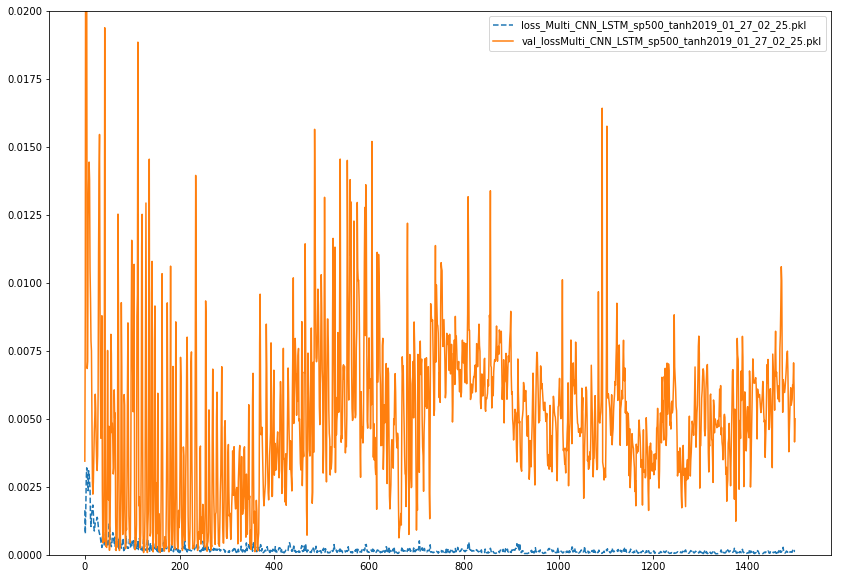

In [58]:
histories = ['Multi_CNN_LSTM_sp500_tanh2019_01_27_02_25.pkl']
plt.figure(figsize=(14,10))
for val in histories:
    with open('H:\Dropbox\python\deep_learning_time_series_forecasting\code\histories\\' + val , 'rb') as file_pi:
        thepickle = pickle.load(file_pi)
        plt.plot(thepickle["loss"],label ='loss_' + val,linestyle='--')
        plt.plot(thepickle["val_loss"],label='val_loss' + val)


plt.legend()
plt.ylim(0, 0.02)

In [59]:
X_t = X_test.reshape((X_test.shape[0], n_seq, n_steps, n_features))

In [60]:
yhat = model.predict(X_t, verbose=2)

In [61]:
max_value = df_index["^GSPC"].max()
min_value = df_index["^GSPC"].min()

In [62]:
pred=pd.DataFrame(yhat, columns=['pred'])
real=pd.DataFrame(y_test, columns=['real'])

In [63]:
max_value, min_value

(2271.719971, 676.53002900000001)

In [64]:
pred['prediction']= pred['pred'].map(lambda a: (a * (max_value - min_value)) + min_value)

In [65]:
real['real_value']= real['real'].map(lambda a: (a * (max_value - min_value)) + min_value)

In [66]:
final=pred.join(real)

In [67]:
final_p=final['prediction'].values
final_r=final['real_value'].values

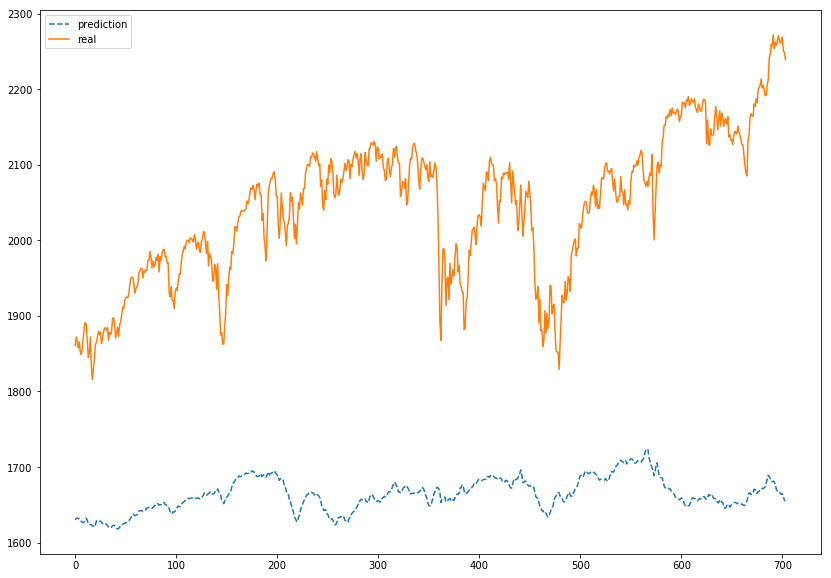

In [68]:
plt.figure(figsize=(14,10))
#plt.plot(raw_seq,label ='original' )
plt.plot(final_p,label ='prediction' ,linestyle='--')
plt.plot(final_r,label='real' )
plt.legend()

In [69]:
from sklearn.metrics import r2_score, mean_squared_error

In [70]:
r2_score(final_p, final_r) 

-320.95593409702485

In [71]:
mean_squared_error(final_p, final_r) 

152397.19393864056